In [1]:
import pandas as pd
import numpy as np
import random

import re 
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xueliufan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xueliufan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xueliufan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/xueliufan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load data

df_politics = pd.read_csv('WELFake_Dataset.csv')
df_politics = df_politics[['title', 'text', 'label']]
df_politics['text'] = df_politics['title']+df_politics['text']
df_politics = df_politics[['text', 'label']]
df_politics = df_politics.dropna()

df_entertainment = pd.read_csv('FakeNewsNet.csv')
df_entertainment = df_entertainment[['title',  'real']]
df_entertainment = df_entertainment.rename(columns={'title': 'text', 'real': 'label'})
df_entertainment = df_entertainment.dropna()

df_healthcare_fake = pd.read_csv('fake.csv')
df_healthcare_fake['label'] = 0
df_healthcare_true = pd.read_csv('true.csv')
df_healthcare_true['label'] = 1
df_healthcare = pd.concat([df_healthcare_fake, df_healthcare_true])
df_healthcare = df_healthcare[['Title', 'Content', 'label']]
df_healthcare['text'] = df_healthcare['Title']+df_healthcare['Content']
df_healthcare = df_healthcare[['text', 'label']]
df_healthcare = df_healthcare.dropna()
df_healthcare


print('-------- Political Dataset --------')
print(df_politics.info())
print(' ')
print('-------- Entertainment Dataset --------')
print(df_entertainment.info())
print(' ')
print('-------- Healthcare Dataset --------')
print(df_healthcare.info())


-------- Political Dataset --------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 71537 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    71537 non-null  object
 1   label   71537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None
 
-------- Entertainment Dataset --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23196 non-null  object
 1   label   23196 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 362.6+ KB
None
 
-------- Healthcare Dataset --------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10179 entries, 0 to 7831
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10179 non-null  object
 1   label   10179 non-null  int64 
dtypes: int64(1)

In [3]:
# combine all the data and shuffle
df = pd.concat([df_politics, df_entertainment, df_healthcare])
df = df.sample( frac=1, random_state = 42).reset_index(drop = True)
df

,text,label
0,Hungary dismisses Estonian compromise offer on...,0
1,Seth McFarlane BRUTALLY Mocks Kellyanne Conwa...,1
2,U.S. House Democratic leader blames Russians f...,0
3,Mitch McConnell Takes Aim At Trump For Praisi...,1
4,Batman Actors Ranked From Worst to Best,1
...,...,...
104907,Italians Rejoice as Soros Ally Mayor Awarded U...,0
104908,Fall in Line,0
104909,"Trump’s civil rights, special education picks ...",1
104910,"Orlando Gunman Was Shot at Least 8 Times, Auto...",0


# Data exploration

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

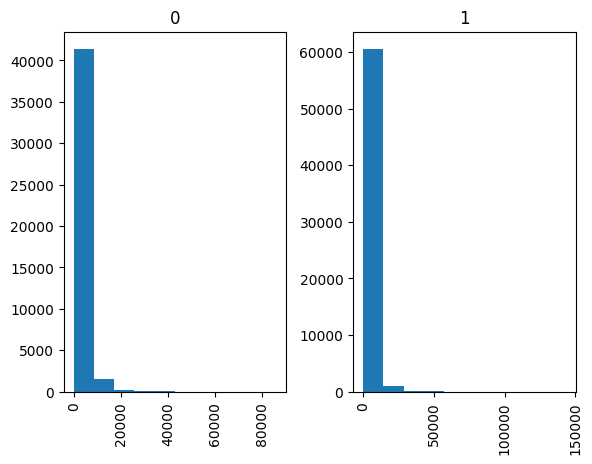

In [4]:
#  the number of characters present in each text by labels
df['text'].str.len().hist(by=df['label'])

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

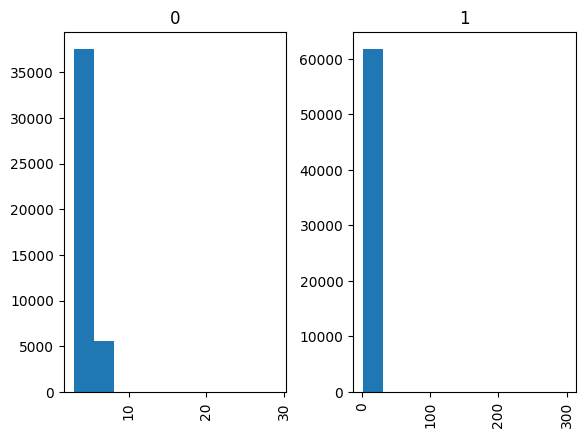

In [5]:
#  the number of words present in each text by labels
df['text'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=df['label'])

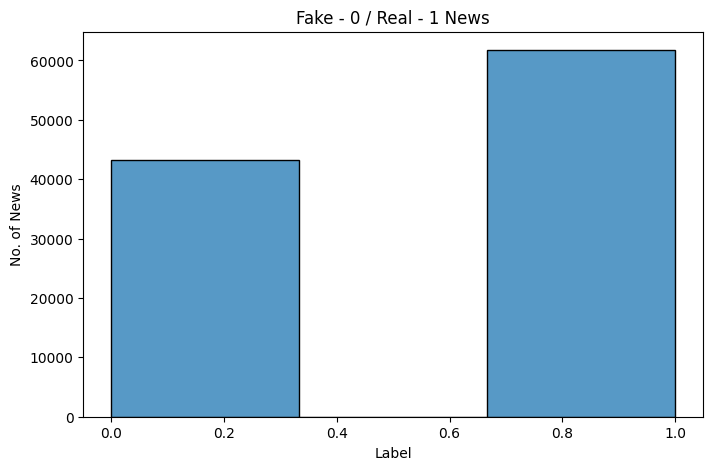

In [6]:
# Data analysis: Fake news - 0 / Real news - 1

plt.figure(figsize = (8,5))
sns.histplot(df['label'], stat='count', bins = 3)
plt.xlabel('Label')
plt.ylabel('No. of News')
plt.title('Fake - 0 / Real - 1 News')
plt.show()

# Data Preprocessing

In [7]:
# Data Preprocessing

def clean_text(text):
    
    """clean the data and tokenize the sentence into words"""
    
    # remove url and html
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text) 
    
    # applied if there is hashtag and @mentioned
    #text = re.sub(r'@\S*', '', text)  
    #text = re.sub(r'#\S*', '', text)
    
    # remove special characters, whitespace, punctuation, and standarize letter
    text = re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = text.strip()
    text = ''.join([w for w in text if w not in string.punctuation])
    
    # remove stopwords
    tokens1 = word_tokenize(text)
    stoplist = stopwords.words('english')
    text = ' '.join([w1 for w1 in tokens1 if not w1 in stoplist])
    
    # convert to root words
    tokens2 = word_tokenize(text)
    lem = nltk.stem.WordNetLemmatizer()
    text = ' '.join([lem.lemmatize(w2, 'v') for w2 in tokens2])
    
    return text



In [8]:
#Process text content

news_df = df.copy()

list_text = news_df['text'].to_list()
processed_text = []
#final_text = []

for text in list_text:
    clean_content = clean_text(text)
    processed_text.append(clean_content)
    
news_df['processed_text'] = processed_text
news_df = news_df[['processed_text', 'label']]


In [9]:
news_df
#df.to_csv('fake_news_data_processed.csv', index = False, encoding = 'utf-8')

,processed_text,label
0,hungary dismiss estonian compromise offer asyl...,0
1,seth mcfarlane brutally mock kellyanne conways...,1
2,us house democratic leader blame russians elec...,0
3,mitch mcconnell take aim trump praise nazisdon...,1
4,batman actors rank worst best,1
...,...,...
104907,italians rejoice soros ally mayor award un pri...,0
104908,fall line,0
104909,trump civil right special education pick face ...,1
104910,orlando gunman shoot least 8 time autopsy find...,0


### Unigram / bigram / trigram analysis

In [10]:
# define n-gram generation function

def ngrams_count(data, n: int): 
    words = data.copy().str.split(' ').explode()
    ngrams = words.copy()
    
    if n == 1:
        ngrams = ngrams.value_counts()   
    else:
        for i in range(1, n):
            ngrams += ' ' + words.groupby(level=0).shift(-i)
        ngrams = ngrams.dropna() 
        ngrams = ngrams.value_counts()

    return ngrams


In [11]:
# split news into true news and fake news by labels

true_news_df = news_df[news_df['label'] == 1]
fake_news_df = news_df[news_df['label'] == 0]

# unigram / bigram / trigram analysis on text in true news

unigrams_text_true = ngrams_count(true_news_df['processed_text'], 1)
bigrams_text_true = ngrams_count(true_news_df['processed_text'], 2)
trigrams_text_true = ngrams_count(true_news_df['processed_text'], 3)

# unigram / bigram / trigram analysis on text in fake news

unigrams_text_fake = ngrams_count(fake_news_df['processed_text'], 1)
bigrams_text_fake = ngrams_count(fake_news_df['processed_text'], 2)
trigrams_text_fake = ngrams_count(fake_news_df['processed_text'], 3)



/var/folders/j4/w4ttg7mj3y1f1lgs8lfmc0nm0000gn/T/ipykernel_2274/1586914339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_df['processed_text'] = fake_news_df['processed_text'].str.lower()
/var/folders/j4/w4ttg7mj3y1f1lgs8lfmc0nm0000gn/T/ipykernel_2274/1586914339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_df['processed_text'] = fake_news_df.processed_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


<AxesSubplot: >

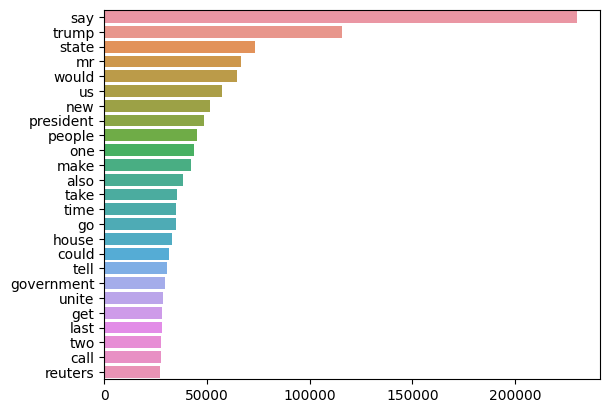

In [12]:
# Corpus analysis corpus_title_fake
stop=set(stopwords.words('english'))
fake_news_df['processed_text'] = fake_news_df['processed_text'].str.lower()
fake_news_df['processed_text'] = fake_news_df.processed_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = fake_news_df['processed_text'].str.split()
new=new.values.tolist()
corpus_title_fake=[word for i in new for word in i]

counter=Counter(corpus_title_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

/var/folders/j4/w4ttg7mj3y1f1lgs8lfmc0nm0000gn/T/ipykernel_2274/1586914339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_df['processed_text'] = fake_news_df['processed_text'].str.lower()
/var/folders/j4/w4ttg7mj3y1f1lgs8lfmc0nm0000gn/T/ipykernel_2274/1586914339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news_df['processed_text'] = fake_news_df.processed_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


<AxesSubplot: >

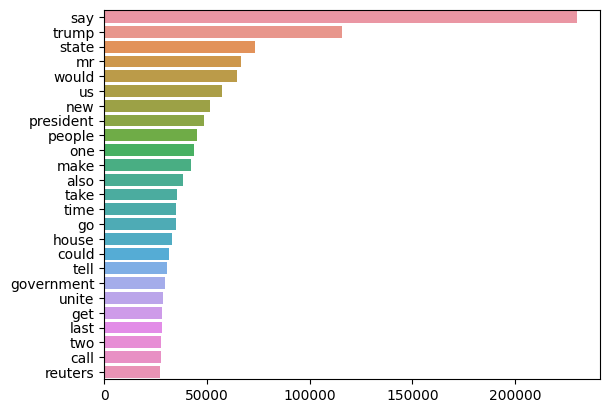

In [13]:
# Corpus analysis corpus_title_fake
stop=set(stopwords.words('english'))
fake_news_df['processed_text'] = fake_news_df['processed_text'].str.lower()
fake_news_df['processed_text'] = fake_news_df.processed_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = fake_news_df['processed_text'].str.split()
new=new.values.tolist()
corpus_title_fake=[word for i in new for word in i]

counter=Counter(corpus_title_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

/var/folders/j4/w4ttg7mj3y1f1lgs8lfmc0nm0000gn/T/ipykernel_2274/280638826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_news_df['processed_text'] = true_news_df['processed_text'].str.lower()
/var/folders/j4/w4ttg7mj3y1f1lgs8lfmc0nm0000gn/T/ipykernel_2274/280638826.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_news_df['processed_text'] = true_news_df.processed_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


<AxesSubplot: >

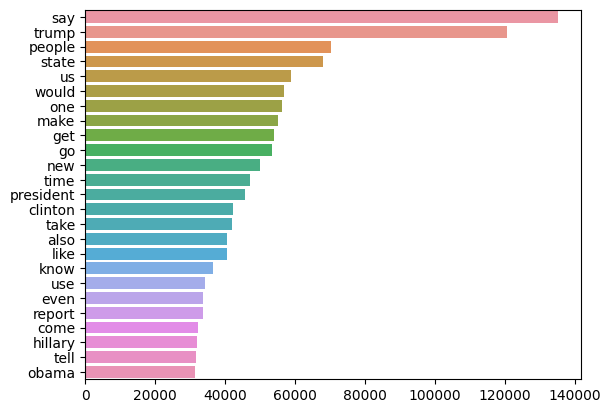

In [14]:
# Corpus analysis corpus_title_fake
stop=set(stopwords.words('english'))
true_news_df['processed_text'] = true_news_df['processed_text'].str.lower()
true_news_df['processed_text'] = true_news_df.processed_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = true_news_df['processed_text'].str.split()
new=new.values.tolist()
corpus_title_fake=[word for i in new for word in i]

counter=Counter(corpus_title_fake)
most=counter.most_common()
x, y= [], []
for word,count in most[:25]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

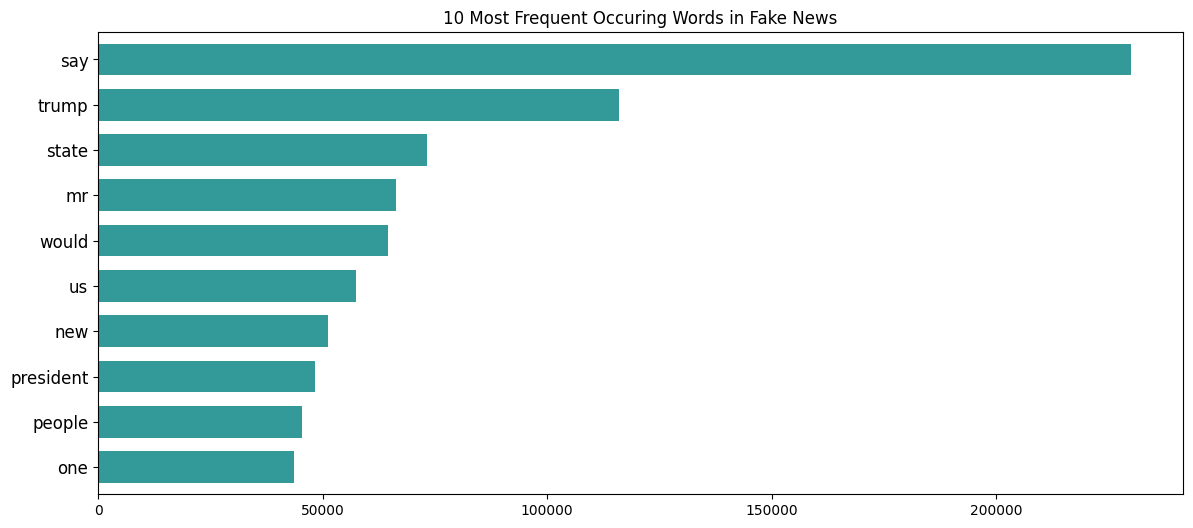

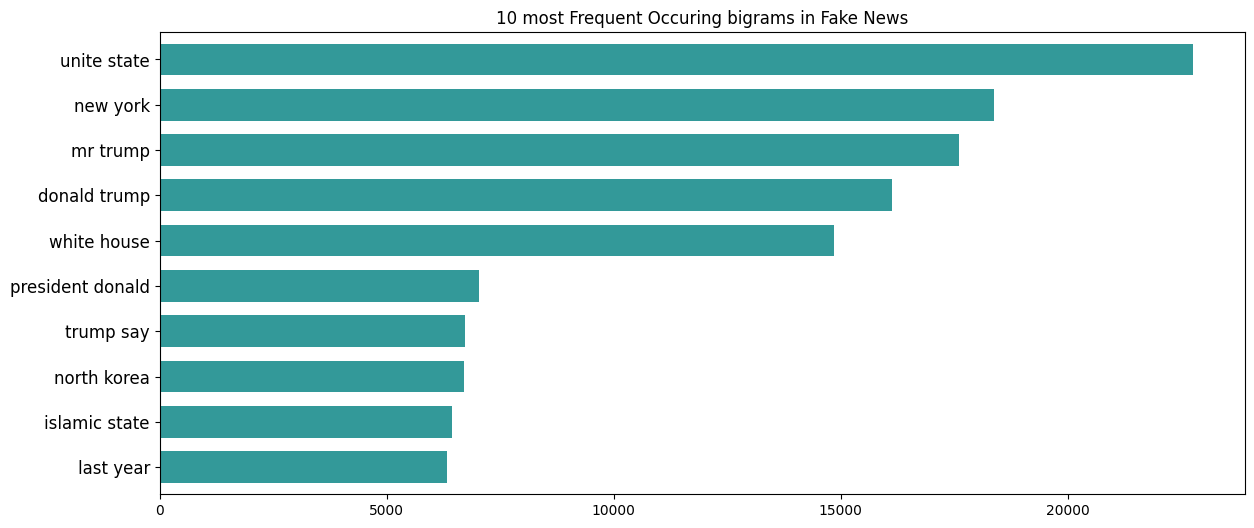

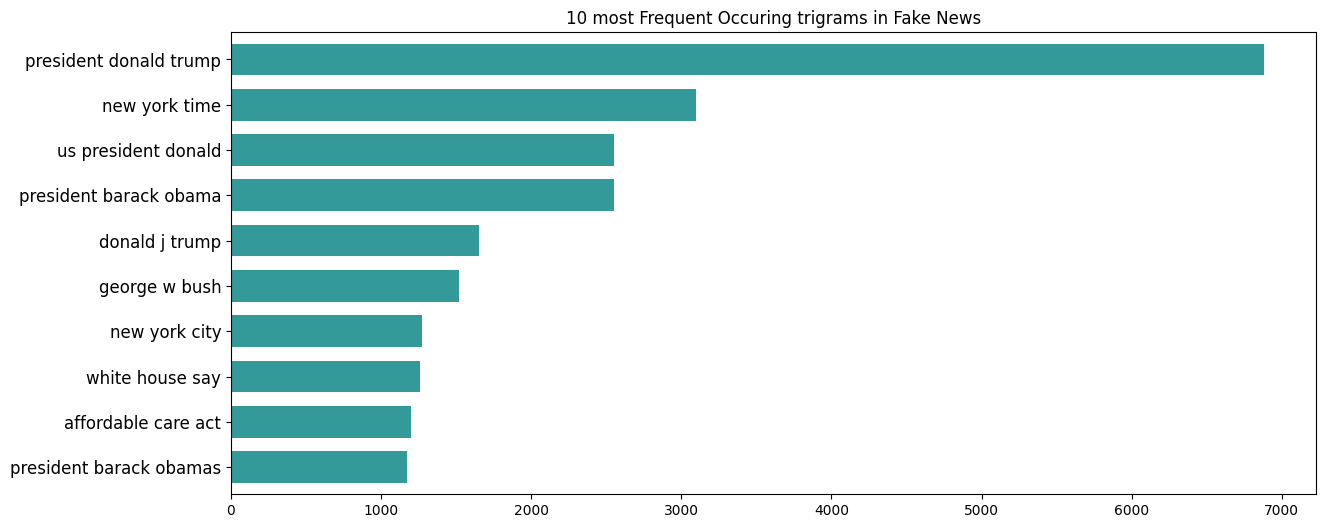

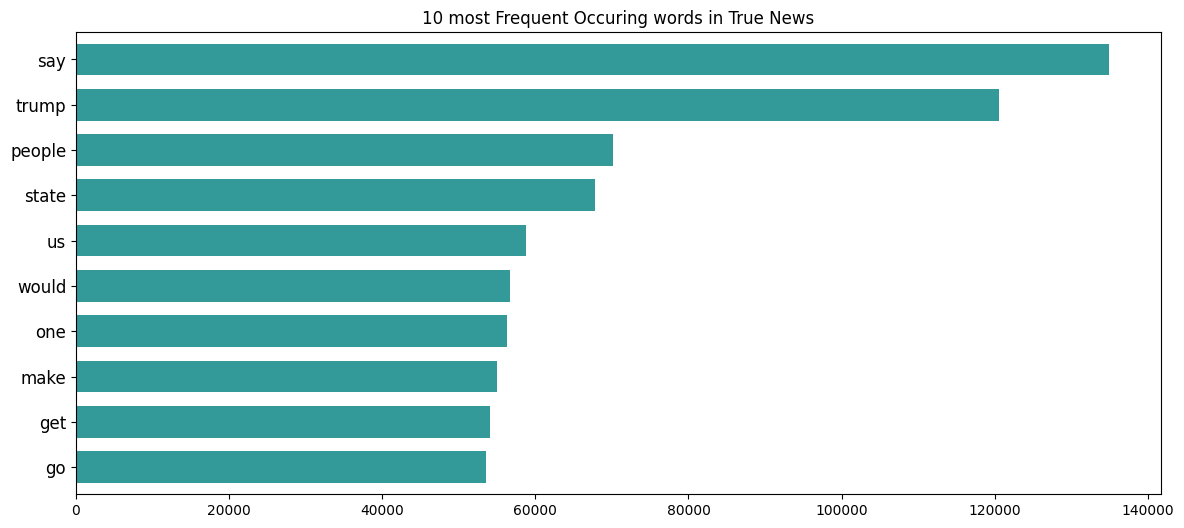

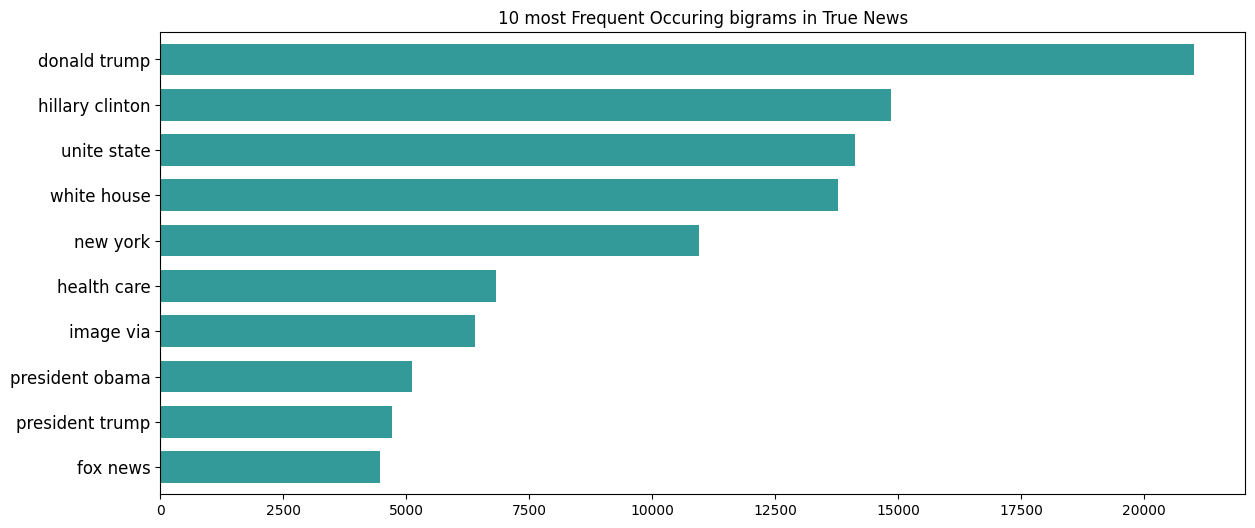

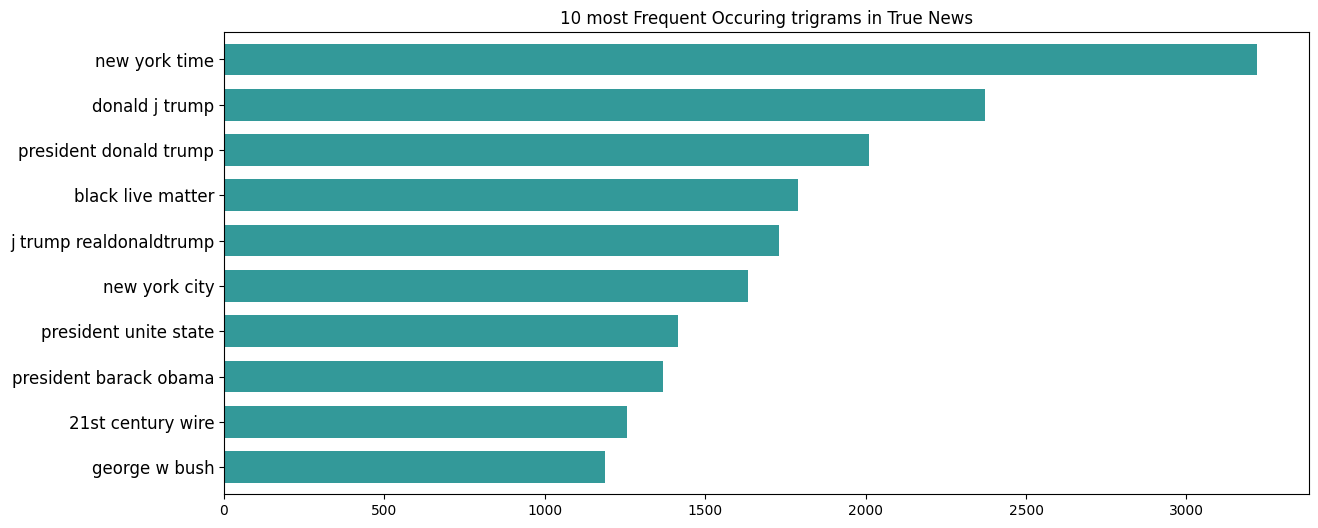

In [15]:
# Visualize unigram/bigram/trigram in news text
#colors = ['gray', 'seagreen', 'red', 'Skyblue', 'brown', 'orchid', 'firebrick', 'green', 'chocolate', 'steelblue' ]

ngram_list = ['10 Most Frequent Occuring Words in Fake News', 
              '10 most Frequent Occuring bigrams in Fake News', 
              '10 most Frequent Occuring trigrams in Fake News',
              '10 most Frequent Occuring words in True News', 
              '10 most Frequent Occuring bigrams in True News', 
              '10 most Frequent Occuring trigrams in True News']
ngram_data = [unigrams_text_fake[:10], bigrams_text_fake[:10], trigrams_text_fake[:10],
              unigrams_text_true[:10], bigrams_text_true[:10], trigrams_text_true[:10]]

for l, var in zip(ngram_list, ngram_data):
    fig, ax = plt.subplots(figsize=(14,6))
    var.sort_values().plot.barh(color = 'teal', width=0.7, alpha = 0.8)
    plt.tick_params(axis='y', which='major', labelsize=12)
    plt.title(l, fontsize=12)
    plt.show()

### Word Cloud

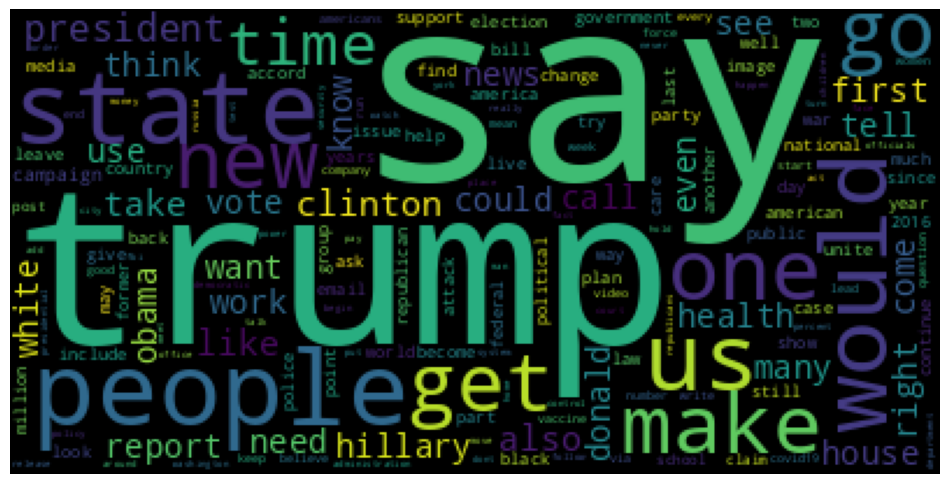

In [16]:
# word cloud of true news

wordcloud_true = WordCloud().generate_from_frequencies(unigrams_text_true)
plt.figure(figsize = (12, 12))
plt.axis('off')
plt.imshow(wordcloud_true)

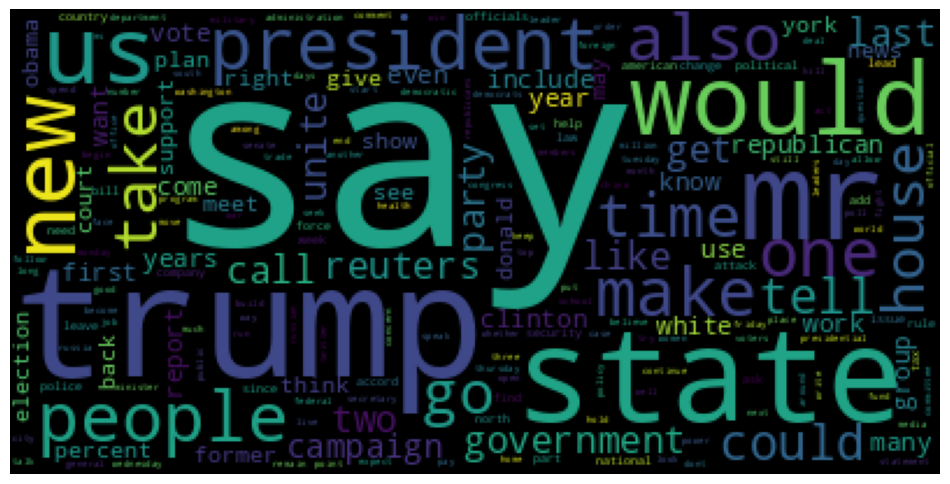

In [17]:
# word cloud of fake news

wordcloud_fake = WordCloud().generate_from_frequencies(unigrams_text_fake)
plt.figure(figsize = (12, 12))
plt.axis('off')
plt.imshow(wordcloud_fake)

In [18]:
# Data preparation

train, test = train_test_split(news_df, test_size=0.25, random_state=42)
train.to_csv('train.csv', index = False, encoding = 'utf-8')
test.to_csv('test.csv', index = False, encoding = 'utf-8')

### Frequent words analysis for different topics

In [19]:
#Process text content

df_temp1 = df_politics.copy()
list_text1 = df_temp1['text'].to_list()
processed_text1 = []
for text in list_text1:
    clean_content = clean_text(text)
    processed_text1.append(clean_content)
df_temp1['processed_text'] = processed_text1
df_temp1 = df_temp1[['processed_text', 'label']]
words1 = ngrams_count(df_temp1['processed_text'], 1)

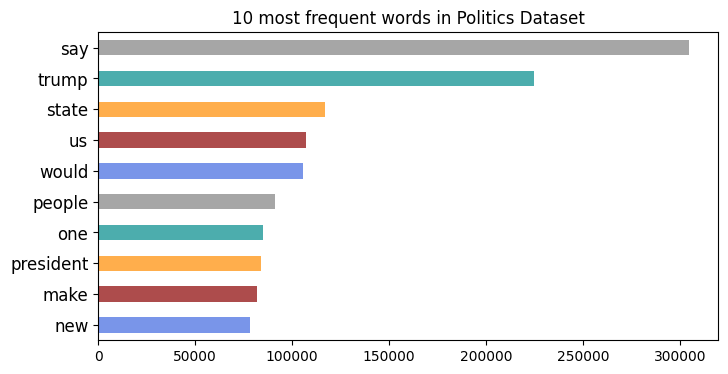

In [20]:
var1 = words1[:10]
fig, ax = plt.subplots(figsize=(8,4))
var1.sort_values().plot(kind='barh', label='index', alpha = 0.7, color=['royalblue', 'darkred', 'darkorange', 'darkcyan', 'grey'])
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('10 most frequent words in Politics Dataset', fontsize=12)
plt.show()


In [21]:
df_temp2 = df_entertainment.copy()
list_text2 = df_temp2['text'].to_list()
processed_text2 = []
for text in list_text2:
    clean_content = clean_text(text)
    processed_text2.append(clean_content)
df_temp2['processed_text'] = processed_text2
df_temp2 = df_temp2[['processed_text', 'label']]
words2 = ngrams_count(df_temp2['processed_text'], 1)

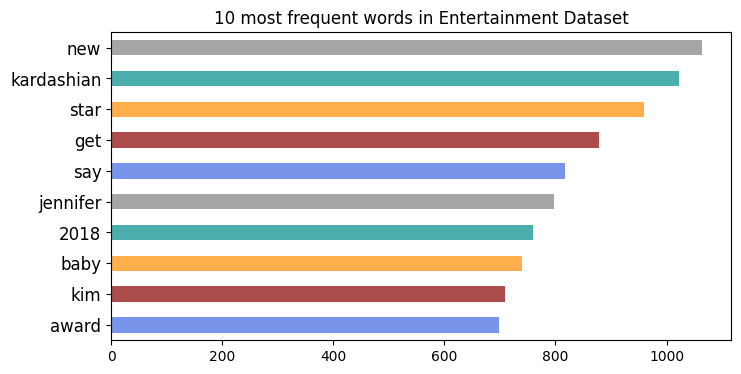

In [22]:
var2 = words2[:10]
fig, ax = plt.subplots(figsize=(8,4))
var2.sort_values().plot(kind='barh', label='index', alpha = 0.7, color=['royalblue', 'darkred', 'darkorange', 'darkcyan', 'grey'])
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('10 most frequent words in Entertainment Dataset', fontsize=12)
plt.show()


In [23]:
df_temp3 = df_healthcare.copy()
list_text3 = df_temp3['text'].to_list()
processed_text3 = []
for text in list_text3:
    clean_content = clean_text(text)
    processed_text3.append(clean_content)
df_temp3['processed_text'] = processed_text3
df_temp3 = df_temp3[['processed_text', 'label']]
words3 = ngrams_count(df_temp3['processed_text'], 1)

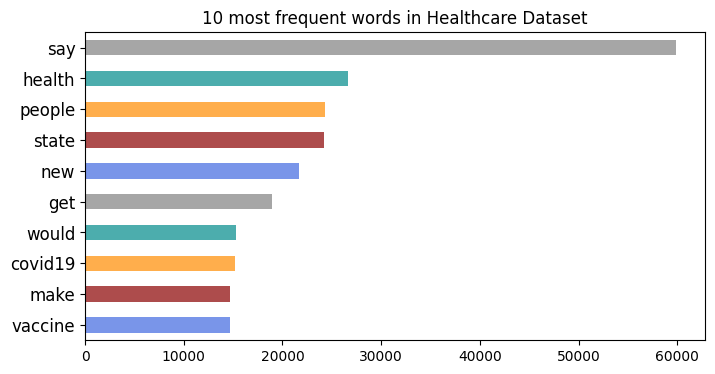

In [24]:
var3 = words3[:10]
fig, ax = plt.subplots(figsize=(8,4))
var3.sort_values().plot(kind='barh', label='index', alpha = 0.7, color=['royalblue', 'darkred', 'darkorange', 'darkcyan', 'grey'])
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('10 most frequent words in Healthcare Dataset', fontsize=12)
plt.show()

In [25]:
df_temp4 = df.copy()
list_text4 = df_temp4['text'].to_list()
processed_text4 = []
for text in list_text4:
    clean_content = clean_text(text)
    processed_text4.append(clean_content)
df_temp4['processed_text'] = processed_text4
df_temp4 = df_temp4[['processed_text', 'label']]
words4 = ngrams_count(df_temp4['processed_text'], 1)


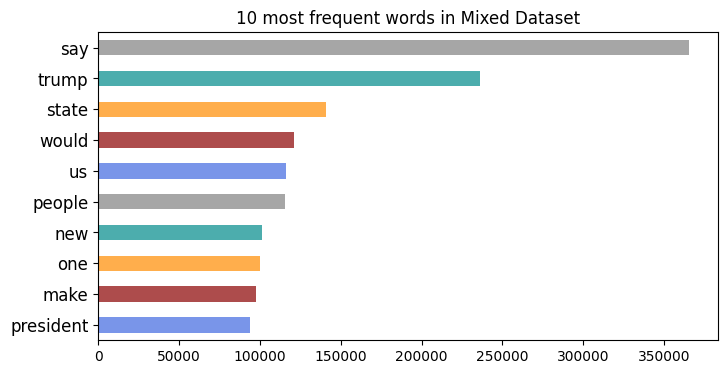

In [26]:
var4 = words4[:10]
fig, ax = plt.subplots(figsize=(8,4))
var4.sort_values().plot(kind='barh', label='index', alpha = 0.7, color=['royalblue', 'darkred', 'darkorange', 'darkcyan', 'grey'])
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('10 most frequent words in Mixed Dataset', fontsize=12)
plt.show()